In [18]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
import datetime
import csv
import os

- Get into the directory with accelerometer recordings

In [4]:
os.chdir(r"./accelerometer_data/")
os.listdir()

['circle', 'square', 'triangle']

In [3]:
# os.chdir("..")
# os.chdir("acc_py")
# os.getcwd()

- Find maximum length of recordings and plot it on a histogram

In [7]:
maxlen = 0
hist_data = []
for shape in os.listdir():
    os.chdir(f"./{shape}")
    print(f"In the {shape} directory")
    for file in os.listdir():
        rec_len = 0
        with open(file, "r") as f:
            reader = csv.reader(f)
            data = list(reader)[1:]
            d_array = np.array(data, dtype = float)
            maxlen = max(maxlen, d_array.shape[0])
            hist_data.append(d_array.shape[0])

    os.chdir("..")


print("Maximum length of recording", maxlen)


In the circle directory
In the square directory
In the triangle directory
83


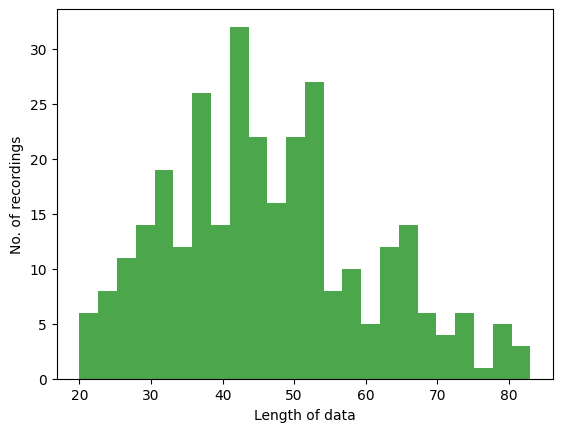

In [8]:
plt.hist(hist_data, int(120/5), color = 'green', alpha = 0.7)
plt.xlabel('Length of data')
plt.ylabel('No. of recordings')
plt.show()

- Culling of recordings that are too long/short (According to the histogram)

In [9]:
rem_shapes = {}
rec_len = 0
for shape in os.listdir():
    os.chdir(f"./{shape}")
    print(f"In the {shape} directory")
    for file in os.listdir():
        rec_len = 0
        with open(file, "r") as f:
            reader = csv.reader(f)
            data = list(reader)[1:]
            d_array = np.array(data, dtype = float)
            rec_len = d_array.shape[0]
        
        if rec_len <= 5 or rec_len > 85:
            os.remove(file)
            rem_shapes[shape] += 1

    os.chdir("..")

print("Removed shape quantities:", rem_shapes)

In the circle directory
In the square directory
In the triangle directory
Removed shape quantities: {}


- Read .csv data

In [11]:
shapes = {}

for shape in os.listdir():
    os.chdir(f"./{shape}")
    print(f"In the {shape} directory")
    for i, file in enumerate(os.listdir()):
        with open(file, "r") as f:
            try:
                reader = csv.reader(f)
                data = list(reader)[1:]
                data.extend([['0.0' for _ in range(3)] for _ in range(83 - len(data))])
                d_array = np.array(data, dtype = float)
                d_array.reshape((1, 83, 3))
                if i == 0:
                    shapes[shape] = d_array
                else:
                    shapes[shape] = np.append(shapes[shape], d_array)
            except Exception as e:
                os.chdir("..")
                raise e
            
    shapes[shape] = shapes[shape].reshape((101, 83, 3))
    print(shape, shapes[shape].shape)
    os.chdir("..")

In the circle directory
circle (101, 83, 3)
In the square directory
square (101, 83, 3)
In the triangle directory
triangle (101, 83, 3)


In [12]:

samples = 101

# Combine data and labels
data = np.vstack((shapes['circle'], shapes['square'], shapes['triangle']))
labels = np.hstack((['circle'] * samples, ['square'] * samples, ['triangle'] * samples))
labels.shape


(303,)

In [13]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)

In [14]:
model = keras.models.Sequential()

model.add(keras.Input(shape = (X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

# Compile the model
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

2024-02-11 12:41:17.236517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-11 12:41:17.571126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-11 12:41:17.571318: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 249)               0         
                                                                 
 dense (Dense)               (None, 32)                8000      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 8691 (33.95 KB)
Trainable params: 8691 (33.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.fit(X_train, y_train, epochs=20, batch_size=1, validation_split=0.2)

Epoch 1/20


/home/risb/Desktop/acc_py/rnn/lib/python3.11/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-02-11 12:41:31.245269: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-11 12:41:31.424565: I external/local_xla/xla/service/service.cc:168] XLA service 0x7693ba4978d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-11 12:41:31.424601: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2024-02-11 12:41:31.443999: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.

193/193 [==============================] - 3s 5ms/step - loss: 1.0534 - accuracy: 0.5130 - val_loss: 0.9555 - val_accuracy: 0.5306
Epoch 2/20
193/193 [==============================] - 1s 4ms/step - loss: 0.6825 - accuracy: 0.7617 - val_loss: 0.8897 - val_accuracy: 0.6531
Epoch 3/20
193/193 [==============================] - 1s 4ms/step - loss: 0.5052 - accuracy: 0.8187 - val_loss: 0.7375 - val_accuracy: 0.7347
Epoch 4/20
193/193 [==============================] - 1s 4ms/step - loss: 0.4163 - accuracy: 0.8342 - val_loss: 0.6689 - val_accuracy: 0.7347
Epoch 5/20
193/193 [==============================] - 1s 4ms/step - loss: 0.3112 - accuracy: 0.8653 - val_loss: 0.8459 - val_accuracy: 0.6735
Epoch 6/20
193/193 [==============================] - 1s 4ms/step - loss: 0.2739 - accuracy: 0.8808 - val_loss: 0.6729 - val_accuracy: 0.7143
Epoch 7/20
193/193 [==============================] - 1s 4ms/step - loss: 0.2181 - accuracy: 0.9119 - val_loss: 0.8366 - val_accuracy: 0.6531
Epoch 8/20
193/19

2/2 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

      circle       0.90      1.00      0.95        18
      square       0.95      0.82      0.88        22
    triangle       0.82      0.86      0.84        21

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.88        61



<Axes: >

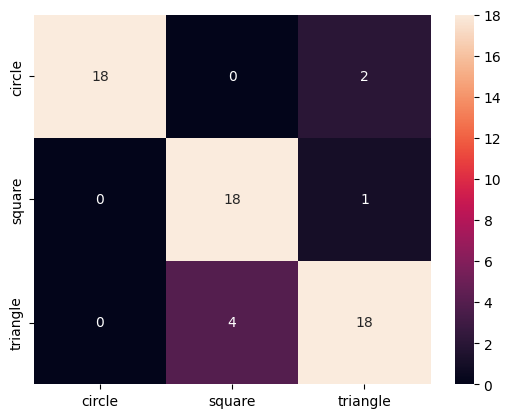

In [19]:
y_pred = np.argmax(model.predict(X_test), axis=1)

# Calculate accuracy
classes = ['circle', 'square', 'triangle']
print(classification_report(y_pred, y_test, target_names=classes))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels=classes, yticklabels=classes)

In [20]:
os.chdir("..")
model.save("acc")

INFO:tensorflow:Assets written to: acc/assets


INFO:tensorflow:Assets written to: acc/assets


In [21]:

random.seed(datetime.datetime.now().microsecond + datetime.datetime.now().second)

model = keras.models.load_model("acc")

def repr_dataset():
    data = shapes[random.choice(['circle', 'square', 'triangle'])][random.randint(0, 100)]
    yield [np.float32(data)]

tflite_name = "acc_edge_small_int8.tflite"

tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_converter.representative_dataset = repr_dataset
tflite_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_converter.inference_input_type = tf.uint8
tflite_converter.inference_output_type = tf.uint8
tflite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = tflite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpladaw0o7/assets


INFO:tensorflow:Assets written to: /tmp/tmpladaw0o7/assets
/home/risb/Desktop/acc_py/rnn/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-02-11 12:46:02.655969: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-11 12:46:02.655989: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-11 12:46:02.656310: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpladaw0o7
2024-02-11 12:46:02.656967: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-11 12:46:02.656978: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpladaw0o7
2024-02-11 12:46:02.658491: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization

In [22]:

open(tflite_name, 'wb').write(tflite_model)

12528

In [23]:
def hex_to_carray(hex_data, var: str) -> str:
    c_str = ''

    # Add header
    c_str += '#pragma once\n\n'
    c_str += 'const unsigned int ' + var + '_len = ' + str(len(hex_data)) + ';\n'
    c_str += 'const unsigned char ' + var + '[] = {\n\t'

    for i, val in enumerate(hex_data):
        c_str += f"0x{val:02x}{',' if i+1 < len(hex_data) else ''}"
        if (i+1) % 100 == 0:
            c_str += '\n\t'
    
    c_str += '\n};\n'

    return c_str

In [24]:
with open('shape_model_int8.hpp', 'w') as f:
    f.write(hex_to_carray(tflite_model, 'shape_model'))

- Copy and paste the .hpp file into the `src` directory of the repo

In [25]:
import random
import datetime


random.seed(datetime.datetime.now().microsecond + datetime.datetime.now().second)

interpreter = tf.lite.Interpreter(model_path='acc_edge_small_int8.tflite')

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.allocate_tensors()

print(input_details)
print(output_details)

# interpreter.set_tensor(input_details[0]['index'], np.float32(shapes['square'][random.randint(0, 100)].reshape((1, 83, 3))))
# interpreter.invoke()

# output_data = interpreter.get_tensor(output_details[0]['index'])

# print(output_data)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 83,  3], dtype=int32), 'shape_signature': array([-1, 83,  3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.008435294032096863, 85), 'quantization_parameters': {'scales': array([0.00843529], dtype=float32), 'zero_points': array([85], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 17, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
